# Polygon pixel planar trap

The following notebook presents initialization, simulation and analysis of ion crystals in polygon traps with *Sion*. 

Contents:

1) n-wire trap initialization  
2) Stability analysis of n-wire trap  
3) Simulation of 10 ions in n-wire trap, 2 species.  
4) Normal mode calculation  


In [1]:
from __future__ import division
import pylion as pl
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from mpl_toolkits.mplot3d import Axes3D
from electrode import (System, PolygonPixelElectrode, PointPixelElectrode, shaped)

import sion as sn


## Trap initialization

The following block initializes the n-wire trap - a planar trap with n parallel electrode lines, which can influence anharmonicity and stability of the trap potential, using a *sion* function. The trap is initialized for 2 ion species: calcium and strontium. 

### Demonstration of n-wire trap design

Simple demonstration for what can be done with n_wire_trap_design function. The function allows to split central wires into separate electrodes, which can be assigned with individual voltages.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


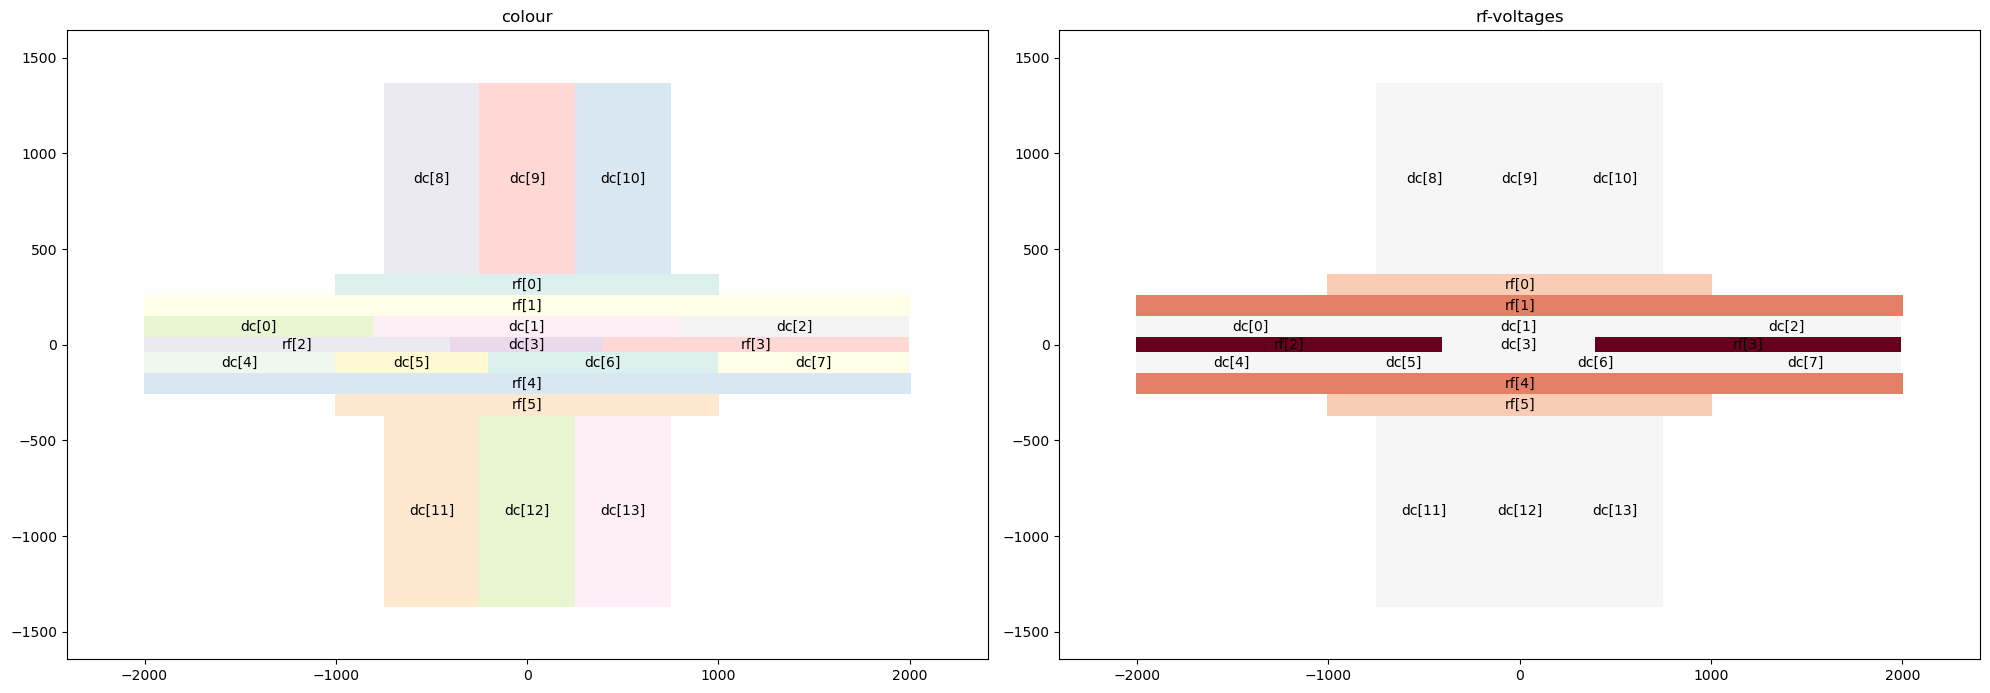

In [2]:
#parameters of trap
top_dc = [[500,1000], [500,1000], [500,1000]] 
bottom_dc = [[500, 1000]]*3 
central_wires = [[2000, 100], [4000, 100], [4000, 100], [4000, 70], [4000, 100], [4000, 100], [2000, 100]]
Urf = 1
rf_indxs = [0, 1, 5, 6]
gap = 10
Urf = [Urf/4, Urf/2, Urf, Urf, Urf/2, Urf/4]
wire_splitting = {2: [[1200, 1600, 1200], []], 3: [[1600, 800, 1600], [0,2]], 4: [[1000, 800, 1200, 1000], []]}

s = sn.n_wire_trap_design(top_dc, bottom_dc, central_wires, rf_indxs, Urf=Urf, gap=10,
                          wire_splitting=wire_splitting, need_plot = True, save_plot = 'n_wire_trap.eps')

### N-rf trap

Definition of the trap, used in the notebook from now on.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


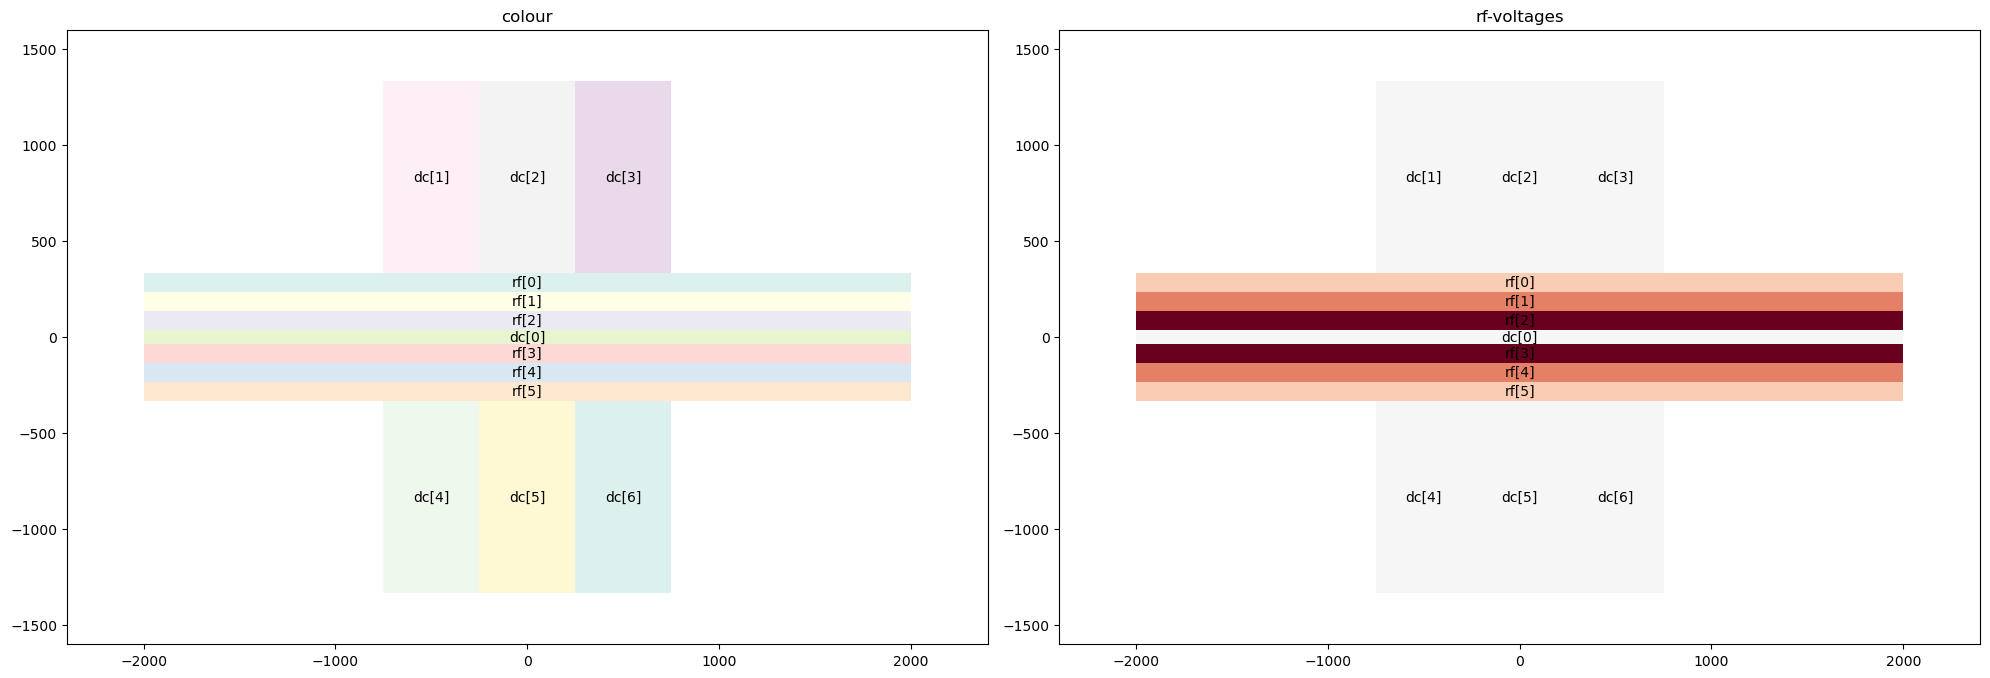

In [14]:
# Global definition of trap parameters. Used for all cells in this notebook
L = 1e-6 # µm length scale
Vrf = 100. # RF peak voltage in V
M_Ca = 40*ct.atomic_mass # ion mass
M_Sr = 88*ct.atomic_mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*40e6 # RF frequency in rad/s
# RF voltage in parametrized form so that the resulting potential equals the RF pseudopotential in eV
Urf_Ca = Vrf*np.sqrt(Z/M_Ca)/(2*L*Omega)
Urf_Sr = Vrf*np.sqrt(Z/M_Sr)/(2*L*Omega)


#parameters of trap
top_dc = [[500,1000], [500,1000], [500,1000]] #x_y
bottom_dc = [[500, 1000]]*3 
central_wires = [[4000, 100], [4000, 100], [4000, 100], [4000, 70], [4000, 100], [4000, 100], [4000, 100]]
rf_indxs = [0, 1,2,4, 5, 6]
Urf_Ca = [Urf_Ca/4, Urf_Ca/2, Urf_Ca, Urf_Ca, Urf_Ca/2, Urf_Ca/4]
Urf_Sr = [Urf_Sr/4, Urf_Sr/2, Urf_Sr, Urf_Sr, Urf_Sr/2, Urf_Sr/4]

s_Ca, RF_electrodes, DC_electrodes = sn.n_wire_trap_design(top_dc, bottom_dc, central_wires, rf_indxs, Urf=Urf_Ca,
                                                           need_coordinates = True, need_plot = True, save_plot = 'n_rf_trap.eps')
s_Sr = sn.n_wire_trap_design(top_dc, bottom_dc, central_wires, rf_indxs, Urf=Urf_Sr)

## Potential characterization

The following block calculates the potential minimum of Ca and Sr ions in the trap, utilizing the *electrode* package functions.

For Calcium:
The minimum is (-7.42e-17, 6.82e-16, 82.3)
Distance from RF-minimum: (-7.42e-17, -4.23e-15, -0.00496) um
Secular frequencies: (0.7364, 4.64, 4.749) MHz
In directions
a: [ 1.  0. -0.] 
b: [ 0.00000000e+00 -1.00000000e+00  1.66533454e-15] 
c: [ 0.00000000e+00 -1.66533454e-15 -1.00000000e+00]
Angle of secular modes rotation alpha: 3.141592638688632
Mathieu frequencies: (0.7364, 4.748, 4.859) MHz

For Strontium:
The minimum is (-2.2e-22, 4.92e-15, 82.3)
Distance from RF-minimum: (0, 0, 0)
Secular frequencies: (0.4965, 2.063, 2.171) MHz
In directions
a: [ 1.  0. -0.] 
b: [ 0.00000000e+00 -1.00000000e+00  2.88657986e-15] 
c: [ 0.00000000e+00 -2.77555756e-15 -1.00000000e+00]
Angle of secular modes rotation alpha: 3.141592653589793


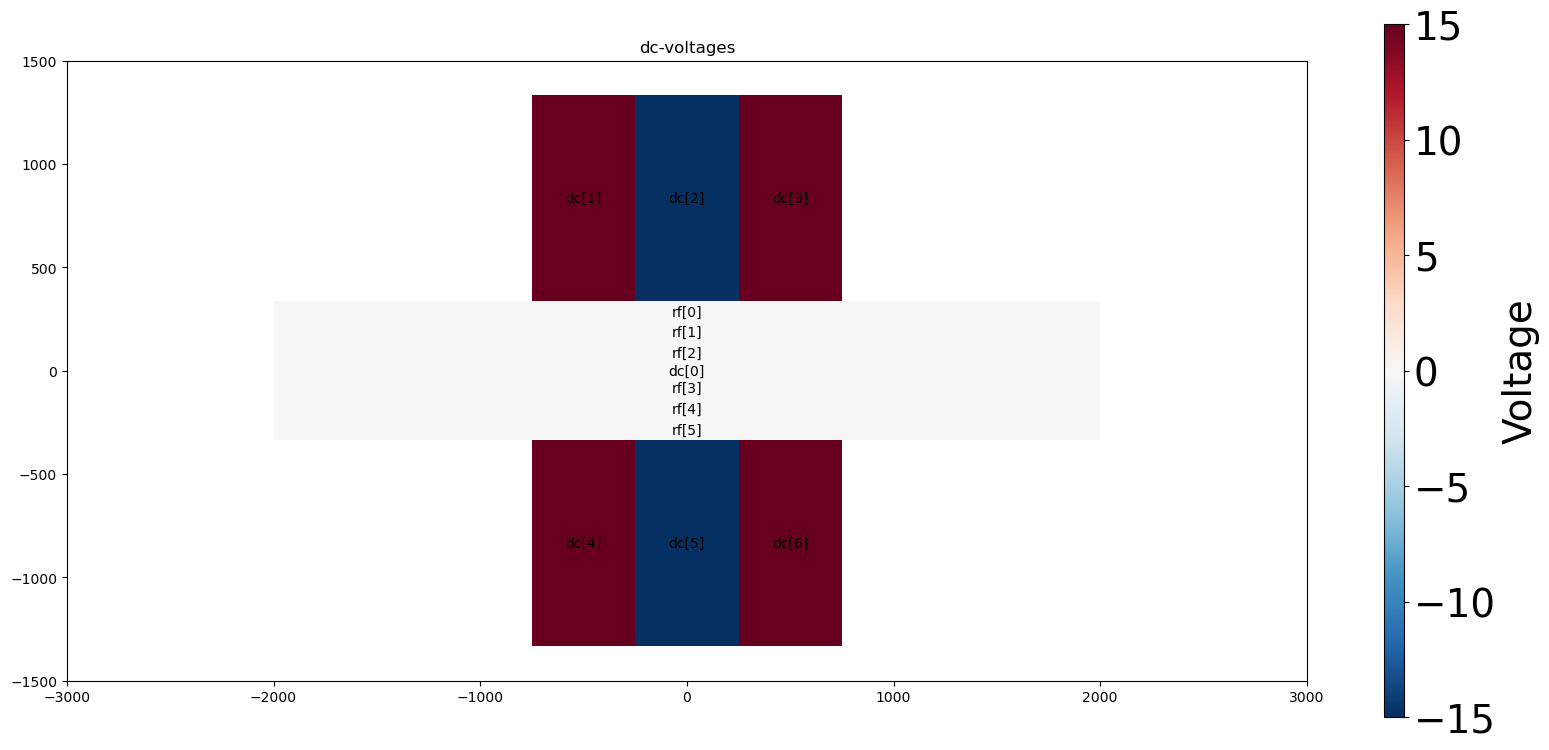

In [18]:
x0 = s_Ca.minimum([0,0,82.45], axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG", options={'maxiter': 1000000})
dc_set = np.array([-0.15, 15, -15, 15, 15, -15, 15])
u_set = np.append(np.zeros(6), dc_set)
rf_set = [Vrf/4, Vrf/2, Vrf, Vrf, Vrf/2, Vrf/4]
omegas = [Omega]*6

with s_Ca.with_voltages(dcs = u_set, rfs = None):
    print('For Calcium:')
    x1 = s_Ca.minimum(x0*1.001, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    print('The minimum is (%.3g, %.3g, %.3g)' % (x1[0], x1[1], x1[2]))
    print('Distance from RF-minimum: (%.3g, %.3g, %.3g) um' % (x1[0] - x0[0], x1[1] - x0[1], x1[2] - x0[2]))
    # Get trap frequencies
    try:
        omega_sec_Ca, mod_dir = sn.single_ion_modes(s_Ca, x1, M_Ca)
        omega_sec_Ca *= 1e-6
        print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec_Ca[0],omega_sec_Ca[1],omega_sec_Ca[2]))
        print("In directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
        e1 = np.array([0,0,1])
        alp = np.arccos(np.inner(mod_dir[2],e1))
        print('Angle of secular modes rotation alpha:', alp)
        
        omega_mathieu, mathieu_modes = sn.single_ion_modes(s_Ca, x1, M_Ca, mathieu=True, Omega=Omega)
        omega_mathieu *= 1e-6
        print("Mathieu frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_mathieu[0],omega_mathieu[1],omega_mathieu[2]))
    except:
        print("Secular frequencies not found")
        
with s_Sr.with_voltages(dcs = u_set, rfs = None):
    print('\nFor Strontium:')
    x1_sr = s_Sr.minimum(x0, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    print('The minimum is (%.3g, %.3g, %.3g)' % (x1_sr[0], x1_sr[1], x1_sr[2]))
    print('Distance from RF-minimum: (%.3g, %.3g, %.3g)' % (x1_sr[0] - x0[0], x1_sr[1] - x0[1], x1_sr[2] - x0[2]))
    # Get trap frequencies
    try:
        omega_sec_Sr, mod_dir = sn.single_ion_modes(s_Sr, x1_sr, M_Sr)
        omega_sec_Sr *= 1e-6
        print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec_Sr[0],omega_sec_Sr[1],omega_sec_Sr[2]))
        print("In directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
        e1 = np.array([0,0,1])
        alp = np.arccos(np.inner(mod_dir[2],e1))
        print('Angle of secular modes rotation alpha:', alp)
        
    except:
        print("Secular frequencies not found")

with s_Ca.with_voltages(dcs = u_set):    
    
    fig, ax = plt.subplots(1,1, figsize=(20, 10))
    s_Ca.plot_voltages(ax, u=s_Ca.dcs)
    #u = s.dcs sets the voltage-type for the voltage plot to DC-voltages (RF are not shown)
    xmax = 3000
    ymaxn = 1500
    ymaxp = 1500
    ax.set_title("dc-voltages")
    ax.set_aspect('equal')
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-ymaxn, ymaxp)
    #Add colorbar
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=np.min(u_set), vmax=np.max(u_set))

    cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink = 0.9, aspect = 35)
    
    """cb = plt.colorbar(ax=ax[2], shrink=0.9)"""
    cb.ax.tick_params(labelsize=28)
    cb.set_label('Voltage', fontsize = 28)

## Stability of ions in planar traps

Dealing with several ions it is important, that both ion species are stable in the trap with chosen parameters. The direct analysis of stability in planar traps is complicated by the assymetry of trap potential, which leads to coupled Mathieu equations, describing 3D motion of ions. For most of the RF planar traps, used for quantum computation, the RF field can be neglected in axial direction. For these kind of traps, *sion* function *stability()* can be used for stability analysis of single/mixed species ions.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


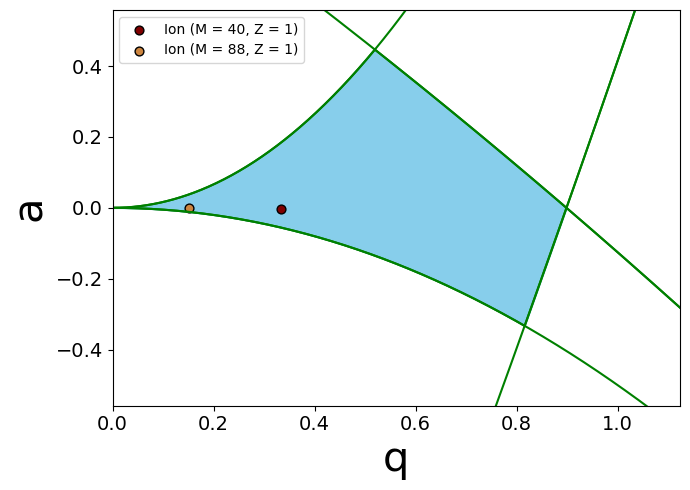

{'Ion (M = 40, Z = 1)': {'a': -0.0019423677930051153, 'q': 0.3340298282916232},
 'Ion (M = 88, Z = 1)': {'a': -0.0008828944513659615, 'q': 0.1518317401325559},
 'α': 0.3020914283611108,
 'θ': 0.0,
 'Range of achievable a': [-0.33303675214832507, 0.4467338059495595],
 'Critical q': 0.8989794855663567}


In [5]:
with s_Ca.with_voltages(dcs = u_set, rfs = rf_set):
    params = sn.stability(s_Ca, [M_Ca, M_Sr], Omega, minimum = x1, save_plot = 'stability_example.eps') 

import pprint
pprint.pprint(params, sort_dicts=False)

## Polygon trap simulation

The following block demonstrates simulation of ion dynamics, performed with generalized *polygon_trap()* function, utilizing *pyLion* package for LAMMPS simulation execution. The *polygon_trap()* function is able to initialize planar ion traps of arbitrary shape, represented by polygonal electrodes.

In [6]:
# simulation of ion crystal
Ca_ion_number = 8
Sr_ion_number = 2
ion_number = Ca_ion_number + Sr_ion_number
x0 = x1*1e-6

#insert your path to this file here
name = Path('polygon_electrode_simulation.ipynb').stem

sim = pl.Simulation(name)

#ion declaration
Caions = {'mass': 40, 'charge': 1}
Srions = {'mass': 88, 'charge': 1}

#placing ions
positions = sn.ioncloud_min(x0, ion_number, 4e-6)
sim.append(pl.placeions(Caions, positions[0:Ca_ion_number]))
sim.append(pl.placeions(Srions, positions[Ca_ion_number:]))

#polygon trap initialization
sim.append(sn.polygon_trap(omegas, rf_set, dc_set, RF_electrodes, DC_electrodes))

#temperature and cooling
sim.append(pl.thermalvelocities(2, False))
sim.append(pl.langevinbath(0, 5e-6))

#file with simulation information
sim.append(pl.dump('positions_polygon.txt', variables=['x', 'y', 'z'], steps=10))
sim.append(pl.evolve(5e5))
try:
    sim.execute()
except:
    pass

Reducing timestep to 1.989436788648692e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  8 settings made for charge
8 atoms in group 1
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  2 settings made for charge
2 atoms in group 2
10 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none


C:\Users\User_A\anaconda3\Lib\site-packages\pylion-0.5.2-py3.11.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


## Ion crystal

The following block demonstrates ion coordinates evolution under cooling during the simulation. Additionally, the formed ion crystal is shown.

Final positions of ions in um:
[[-15.66   0.    82.3 ]
 [-11.46   0.    82.32]
 [ -7.91  -0.    82.33]
 [ -4.66   0.    82.34]
 [ -1.54  -0.    82.31]
 [  1.54   0.    82.34]
 [  4.66  -0.    82.33]
 [  7.91   0.    82.33]
 [ 11.46  -0.    82.28]
 [ 15.66  -0.    82.3 ]]
Potential-based equilibrium ion positions in um:
[[-15.66   0.    82.3 ]
 [-11.46  -0.    82.32]
 [ -7.91   0.    82.33]
 [ -4.66  -0.    82.34]
 [ -1.54   0.    82.31]
 [  1.54  -0.    82.34]
 [  4.66  -0.    82.33]
 [  7.91   0.    82.33]
 [ 11.46   0.    82.28]
 [ 15.66   0.    82.3 ]]
Difference from simulation in um:
[[-0.001  0.     0.   ]
 [-0.001 -0.    -0.   ]
 [-0.001  0.    -0.   ]
 [-0.001 -0.     0.   ]
 [-0.001  0.001 -0.001]
 [-0.001 -0.     0.   ]
 [-0.001 -0.     0.   ]
 [-0.002  0.    -0.   ]
 [-0.002  0.     0.   ]
 [-0.003  0.    -0.   ]]


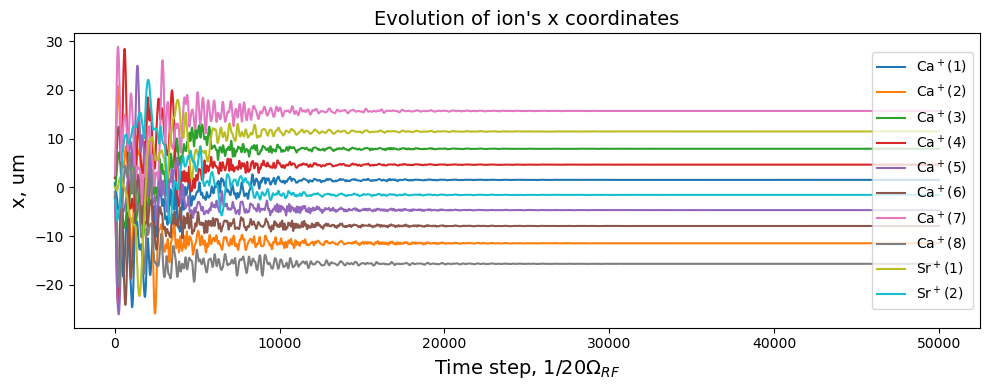

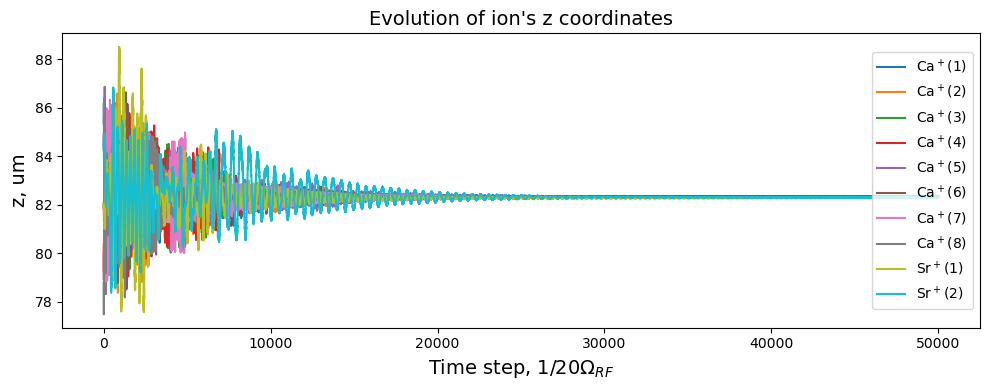

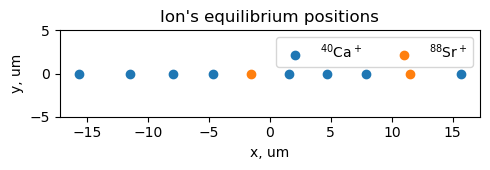

In [7]:
Ca_ion_number = 8
Sr_ion_number = 2
ion_number = Ca_ion_number + Sr_ion_number
_, data = pl.readdump('positions_polygon.txt')

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

data *= 1e6

sort = np.argsort(final_x)

final_positions = []
ion_masses = []
omegas = []

k=0
for i in sort:
    final_positions.append(np.array([np.mean(data[49000:, i, 0]), np.mean(data[49000:, i, 1]), np.mean(data[49000:, i, 2])]))
    if i<Ca_ion_number:
        ion_masses.append(M_Ca)
        omegas.append(1e6*omega_sec_Ca)
    else:
        ion_masses.append(M_Sr)
        omegas.append(1e6*omega_sec_Sr)
    k+=1

equilibrium_positions = sn.equilibrium_ion_positions(s_Ca, dc_set, ion_masses, ion_number, potential_minimum = x1, positions_guess=None)

print(f'Final positions of ions in um:\n{np.round(final_positions, 2)}')
print(f'Potential-based equilibrium ion positions in um:\n{np.round(equilibrium_positions, 2)}')
print(f'Difference from simulation in um:\n{np.round(equilibrium_positions - final_positions, 3)}')

fs = 14
fss = 16

# Plot of ion crystal evolution
plt.figure(figsize = (10,4))
for n in range(ion_number):
    if n < Ca_ion_number:
        plt.plot(data[:, n, 0], label = f'Ca$^+$({n + 1})')
    else:
        plt.plot(data[:, n, 0], label = f'Sr$^+$({n - Ca_ion_number + 1})')
plt.title('Evolution of ion\'s x coordinates', fontsize = fs)
plt.xlabel('Time step, $1/20\Omega_{RF}$', fontsize = fs)
plt.legend(loc = 'right')
plt.ylabel('x, um', fontsize = fs)
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,4))
for n in range(ion_number):
    if n < Ca_ion_number:
        plt.plot(data[:, n, 2], label = f'Ca$^+$({n + 1})')
    else:
        plt.plot(data[:, n, 2], label = f'Sr$^+$({n - Ca_ion_number + 1})')
plt.title('Evolution of ion\'s z coordinates', fontsize = fs)
plt.xlabel('Time step, $1/20\Omega_{RF}$', fontsize = fs)
plt.ylabel('z, um', fontsize = fs)
plt.legend(loc = 'right')
plt.tight_layout()


plt.show()

# Plot of the final ion crystal configuration
plt.figure(figsize = (5, 1.8))
plt.scatter(data[-1, :Ca_ion_number, 0], data[-1, :Ca_ion_number, 1], label = '$^{40}$Ca$^+$')
plt.scatter(data[-1, Ca_ion_number:, 0], data[-1, Ca_ion_number:, 1], label = '$^{88}$Sr$^+$')
plt.title('Ion\'s equilibrium positions')
plt.xlabel('x, um')
plt.ylabel('y, um')
plt.legend(ncol = 2)
plt.yticks([5,0,-5])
plt.ylim([-5,5])
plt.tight_layout()

plt.show()


data *= 1e-6

## Mixed-species normal modes calculation

The normal modes of oscillation of ion crystals of arbitrary shape (see *2D_crystal_modes.ipynb*, *individual_wells_voltage_optimization.ipynb*), tweezer and isotope configuration can be calculated by *sion* package function *normal_modes()*. The following block demonstrates modes in 'y' principle oscillation axis, showing the spectral separation of Sr ions from the main bulk Ca ions in radial normal modes.

Mode index: 0, frequency: 0.75 MHz
Mode index: 1, frequency: 1.57 MHz
Mode index: 2, frequency: 3.4 MHz
Mode index: 3, frequency: 3.61 MHz
Mode index: 4, frequency: 3.92 MHz
Mode index: 5, frequency: 4.07 MHz
Mode index: 6, frequency: 4.37 MHz
Mode index: 7, frequency: 4.42 MHz
Mode index: 8, frequency: 4.49 MHz
Mode index: 9, frequency: 4.58 MHz


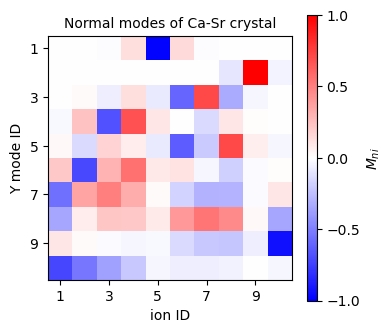

In [9]:
##### '''Phonon modes of the ion crystal'''
freqs, modes = sn.normal_modes(equilibrium_positions*L, omegas, ion_masses, linear = True)
freqs[1] *= 1e-6
y_modes = modes[1]

#freqs = freqs[::-1]

for i, freq in enumerate(freqs[1]):
    print(f'Mode index: {i}, frequency: {round(freq, 2)} MHz')

plt.figure(figsize = (4,4))
plt.imshow(y_modes[:, :] / np.max(np.abs(y_modes[1])), cmap='bwr', vmin = -1, vmax = 1)
cb = plt.colorbar(shrink = 0.8, aspect = 30, ticks = [-1, -0.5, 0, 0.5, 1])
cb.set_label('$M_{ni}$')
plt.xlabel('ion ID')
plt.ylabel('Y mode ID')
plt.yticks([0, 2, 4, 6, 8],[1, 3, 5, 7, 9])
plt.xticks([0, 2, 4, 6, 8],[1, 3, 5, 7, 9])
plt.title('Normal modes of Ca-Sr crystal', fontsize = 10)
plt.tight_layout()
plt.show()